# Exploratory Data Analysis of Acceleration-Behavior Data


In this notebook, we conduct explorations on the accceleration data, available behavior annotations, and matched acceleration-behavior pairs. The findings from these explorations are decsribed in Section 3 of our paper.

In [9]:
import os
import sys
import ast
import time
sys.path.append('.')
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.io import (get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_figures_dir)

from src.utils.plot import plot_raw_time_series

from src.utils.data import (create_data_tensors,
                            adjust_behavior_and_durations,
                            create_data_tensors,
                            create_matched_data)
                            
from src.data_prep.data_prep_utils import combined_annotations

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             VECTRONICS_AUDIO_ANNOTATIONS_PATH,
                             VECTRONICS_VIDEO_ANNOTATIONS_PATH,
                             id_mapping,
                             VECTRONICS_METADATA_PATH)

In [10]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

First let us load dataframes for matched acceleration-behavior pairs and their metadata. These objects are created by running `src/data_prep/create_matched_data_objects.py` script. Next we extract fixed length windows from the acceleration data.

In [23]:
# load matched acceleration and label pairs data, metadata, and summary

acc_data = pd.read_csv(get_matched_data_path())
acc_metadata = pd.read_csv(get_matched_metadata_path())
acc_summary = pd.read_csv(get_matched_summary_path())

In [5]:
all_annotations = combined_annotations(video_path=VECTRONICS_VIDEO_ANNOTATIONS_PATH, 
                                        audio_path=VECTRONICS_AUDIO_ANNOTATIONS_PATH,
                                        id_mapping=id_mapping) # load annotations 
metadata = pd.read_csv(VECTRONICS_METADATA_PATH) # load metadata

start = time.time()
_, df, _ = create_matched_data(metadata, all_annotations)
lag = time.time() - start
print(f'Total time - {lag:.2f}, average time - {(lag/len(df))}')

Dog jessie has 506 halfdays in the filtered metadata.


Processing unique half days for jessie: 100%|██████████| 506/506 [00:49<00:00, 10.25it/s]


Dog green has 900 halfdays in the filtered metadata.


Processing unique half days for green: 100%|██████████| 900/900 [00:38<00:00, 23.30it/s]


Dog palus has 744 halfdays in the filtered metadata.


Processing unique half days for palus: 100%|██████████| 744/744 [00:04<00:00, 171.56it/s] 


Dog ash has 792 halfdays in the filtered metadata.


Processing unique half days for ash: 100%|██████████| 792/792 [00:37<00:00, 21.40it/s]


Dog fossey has 448 halfdays in the filtered metadata.


Processing unique half days for fossey: 100%|██████████| 448/448 [00:19<00:00, 23.35it/s]

Total time - 148.69, average time - 0.014647876907482416


In [28]:
# data filtration: 
# Step 1: filter out five behaviors of interest - feeding, moving, running, vigilant, and resting.
# Step 2: Remove behaviors of duration < 1 second.
# Step 3: Remove feeding, moving, and running behaviors of duration < 8 seconds.

acc_data = adjust_behavior_and_durations(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS, verbose=True)
window_duration = np.percentile(acc_data['duration'].values, 50)
print(f'Median duration in filtered data - {window_duration}')

Total behavior duration before filtering - 72.21169222222223
Total duration after filtering out chosen behaviors is 72.21169222222223 hrs.
Total behavior duration after filtering is 72.21169222222223 hrs.
Median duration in filtered data - 12.937


In [14]:
# create fixed duration 'window_duration' windows.
X, y, z = create_data_tensors(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS, SAMPLING_RATE, 
                        padding='repeat', reuse_behaviors=BEHAVIORS, min_duration=1.0, duration_percentile=50)

Duration of window is 12.937 sec.


In [34]:
# class imbalance numbers 

print(f' Majority classes - ', np.isin(y, ['Resting', 'Vigilant']).sum()/len(y))
print(f' Feeding classes - ', np.isin(y, ['Feeding']).sum()/len(y))

 Majority classes -  0.9396610749743238
 Feeding classes -  0.02092605272167066


In [35]:
# behavior-wise summary of durations

behavior_EDA = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].sum()/3600)
behavior_EDA = behavior_EDA.rename(columns={'duration': 'total duration [h]'})
behavior_EDA['average duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].mean())['duration']
behavior_EDA['Min duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].min())['duration']
behavior_EDA['Max duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].max())['duration']

print(behavior_EDA.sort_values(by='Source').round(2))

                 total duration [h]  average duration [s]  Min duration [s]  \
behavior Source                                                               
Feeding  Audio                 0.20                 50.65              7.94   
Moving   Audio                 0.39                 43.56              3.94   
Running  Audio                 0.48                 40.38              3.94   
Vigilant Audio                 0.05                 11.40              3.94   
Feeding  Video                 1.32                 34.39              8.94   
Moving   Video                 1.67                 15.22              8.94   
Resting  Video                51.57                 85.28              1.94   
Running  Video                 0.09                 17.73              8.94   
Vigilant Video                16.45                 17.02              1.94   

                 Max duration [s]  
behavior Source                    
Feeding  Audio             176.94  
Moving   Audio        

In [36]:
# individual-wise summary of durations

temp = z.copy()
temp['behavior'] = y
grouped_individual = pd.DataFrame(temp.groupby(['dog ID'])['year'].count()).reset_index()
grouped_individual = grouped_individual.rename(columns={'year':'count'})
print(grouped_individual)

   dog ID  count
0     ash   4555
1  fossey   2275
2   green   6987
3  jessie   9183
4   palus    368


In [37]:
# behavior-wise summary of windows

temp = z.copy()
temp['behavior'] = y
grouped_behaviors = pd.DataFrame(temp.groupby(['Source', 'behavior'])['year'].count()).reset_index()
grouped_behaviors = grouped_behaviors.rename(columns={'year':'count'})
grouped_behaviors['proportion'] = round(100*grouped_behaviors['count']/sum(grouped_behaviors['count']), 2)
print(grouped_behaviors)

  Source  behavior  count  proportion
0  Audio   Feeding     60        0.26
1  Audio    Moving    120        0.51
2  Audio   Running    153        0.65
3  Audio  Vigilant     20        0.09
4  Video   Feeding    429        1.84
5  Video    Moving    616        2.64
6  Video   Resting  15442       66.08
7  Video   Running     32        0.14
8  Video  Vigilant   6496       27.80


In [38]:
print(X.shape, y.shape, len(z))

# individual-wise summary of windows

temp = z.copy()
temp['behavior'] = y
print(pd.DataFrame(temp.groupby('dog ID')['year'].count()))

(23368, 3, 206) (23368,) 23368
        year
dog ID      
ash     4555
fossey  2275
green   6987
jessie  9183
palus    368


In [39]:
dog_EDA = pd.DataFrame(acc_data.groupby('dog ID')['UTC Date [yyyy-mm-dd]'].agg(['min', 'max', 'nunique'])).reset_index()
dog_EDA['duration'] = pd.DataFrame(round(acc_data.groupby('dog ID')['duration'].sum()/3600, 2)).reset_index()['duration']
dog_EDA['total obs'] = pd.DataFrame(acc_data.groupby('dog ID')['duration'].count()).reset_index()['duration']
dog_EDA.columns = ['dog ID', 'start date', 'end date', 'no. of days', 'duration (h)', 'total obs']
print(dog_EDA)

   dog ID  start date    end date  no. of days  duration (h)  total obs
0     ash  2021-10-25  2021-11-13           11         13.71       1436
1  fossey  2022-07-14  2022-07-20            5          6.95        668
2   green  2021-09-03  2021-09-22           13         21.42       1909
3  jessie  2022-08-01  2022-08-16           15         29.04       2177
4   palus  2021-10-27  2021-11-12            2          1.09        121


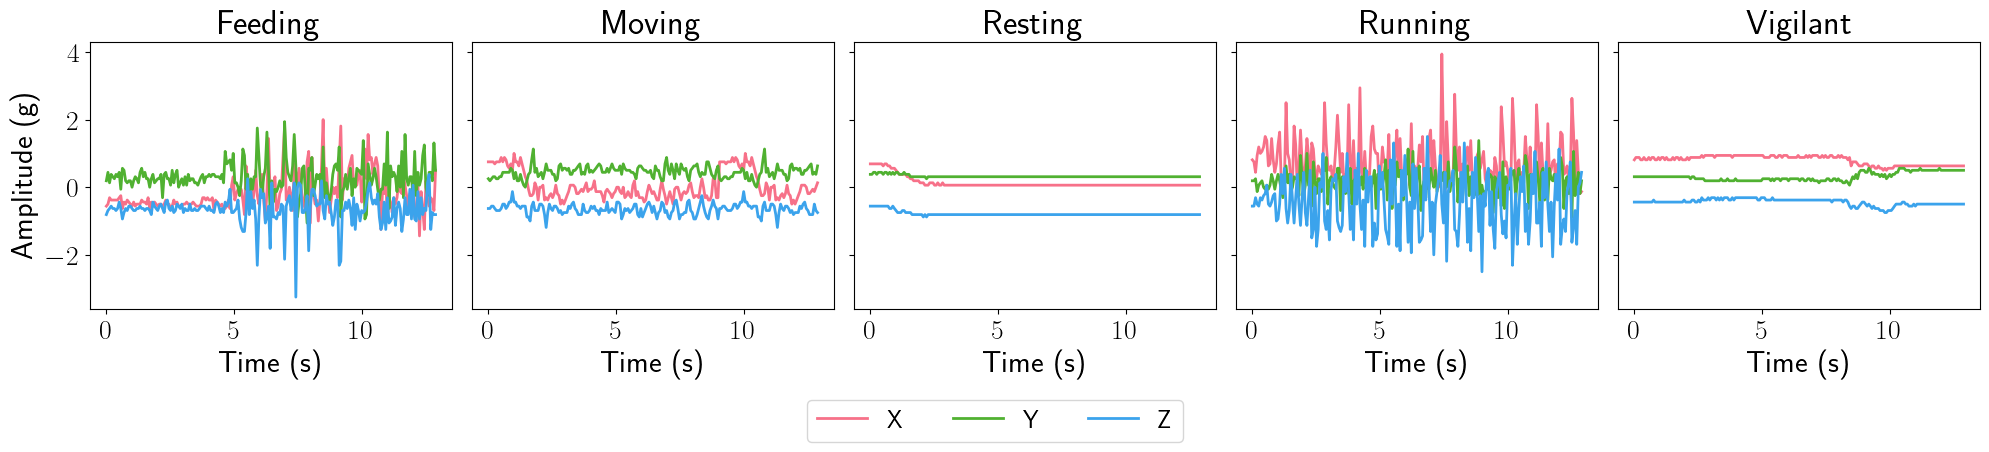

In [40]:
# representative waveforms
fig_path = os.path.join(get_figures_dir(), 'behaviors_trace.png')
plot_raw_time_series(X, y, save_path=fig_path)

Now let us visualize multiple instances of each behavior to observe key difference in acceleration profile of each behavior.

#### Running

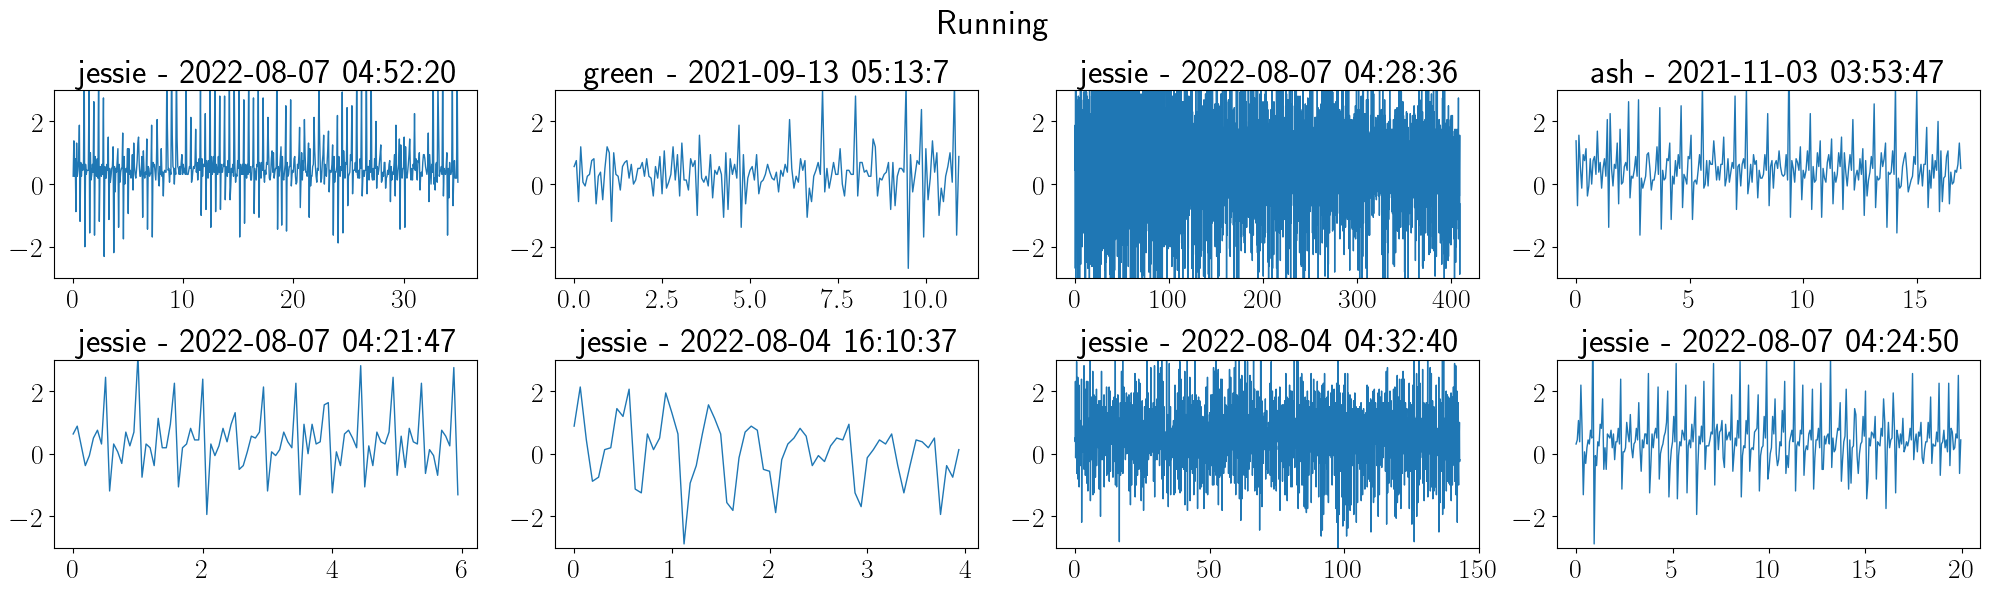

In [81]:
running_data = acc_data[acc_data['behavior'] == 'Running'].reset_index(drop=True)
idx = np.random.choice(range(0, len(running_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(running_data.iloc[idx[i]]['acc_x']))/16, running_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = running_data.iloc[idx[i]]['dog ID'], pd.to_datetime(running_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Running', fontsize=25)
plt.tight_layout()
plt.show()


#### Feeding

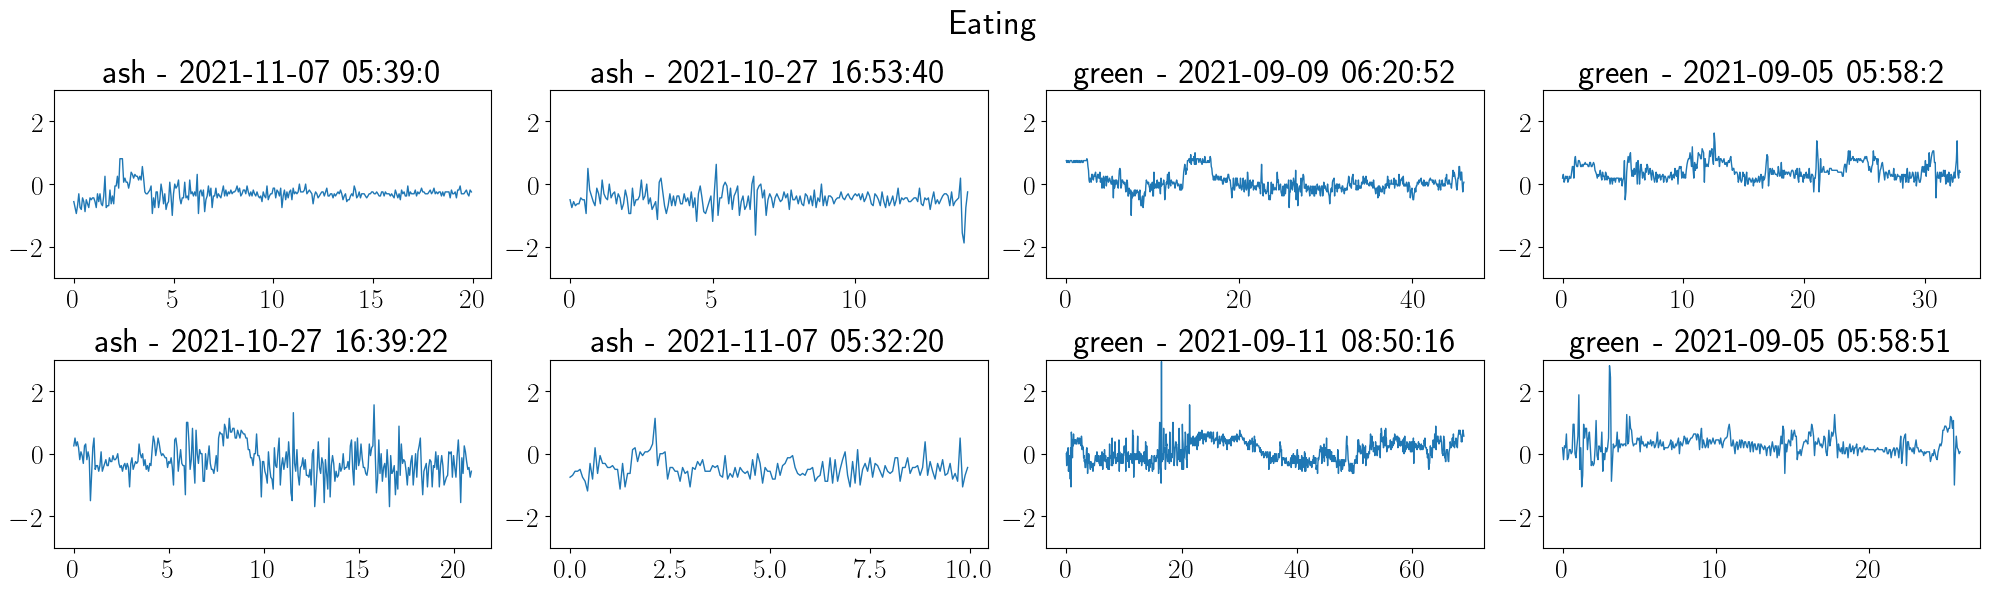

In [84]:
eating_data = acc_data[acc_data['behavior'] == 'Eating'].reset_index(drop=True)
idx = np.random.choice(range(0, len(eating_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(eating_data.iloc[idx[i]]['acc_x']))/16, eating_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = eating_data.iloc[idx[i]]['dog ID'], pd.to_datetime(eating_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Eating', fontsize=25)
plt.tight_layout()
plt.show()


#### Moving

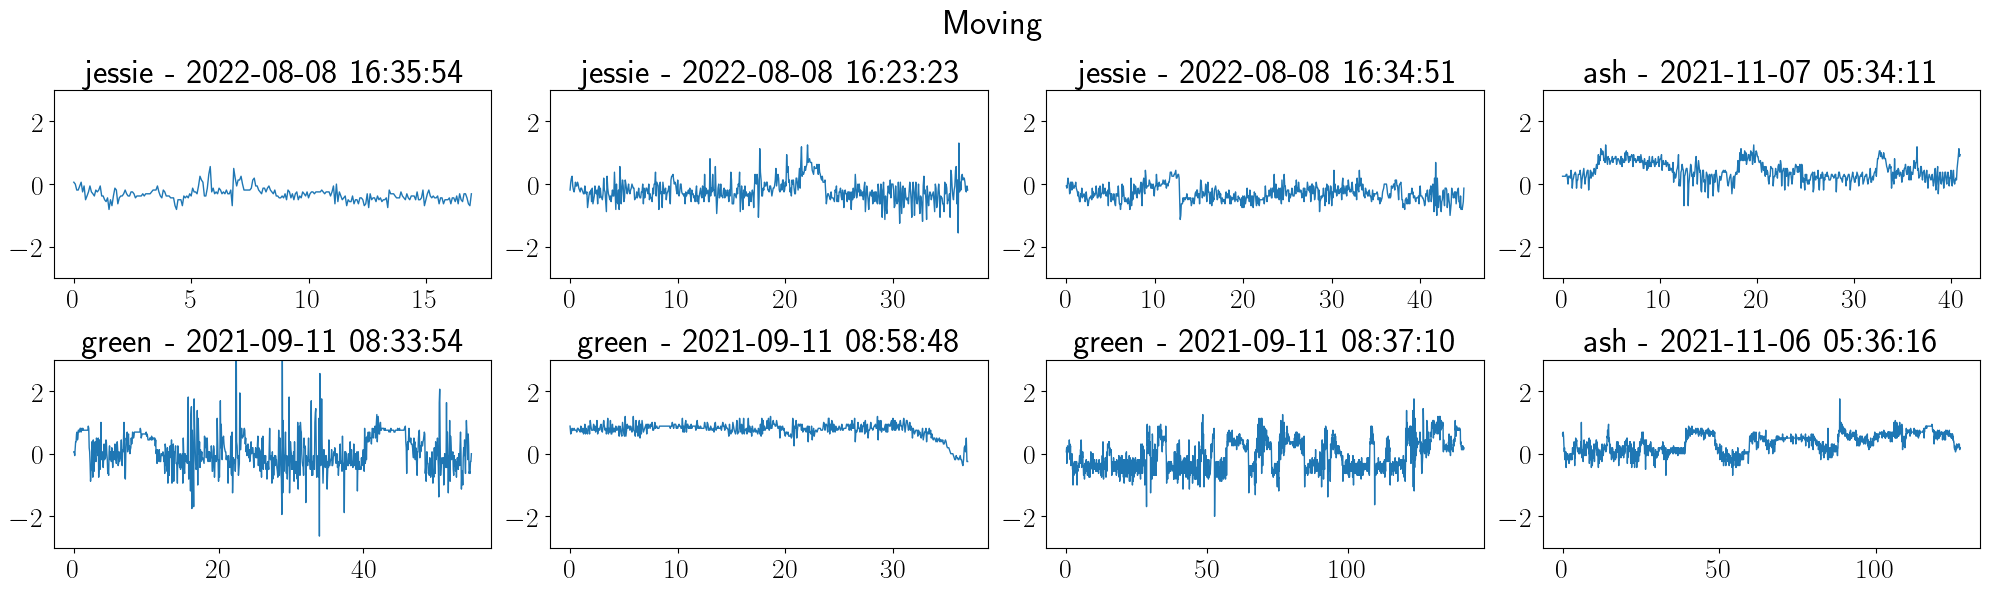

In [85]:
moving_data = acc_data[acc_data['behavior'] == 'Eating'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(moving_data.iloc[idx[i]]['acc_x']))/16, moving_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = moving_data.iloc[idx[i]]['dog ID'], pd.to_datetime(moving_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Moving', fontsize=25)
plt.tight_layout()
plt.show()


#### Vigilant

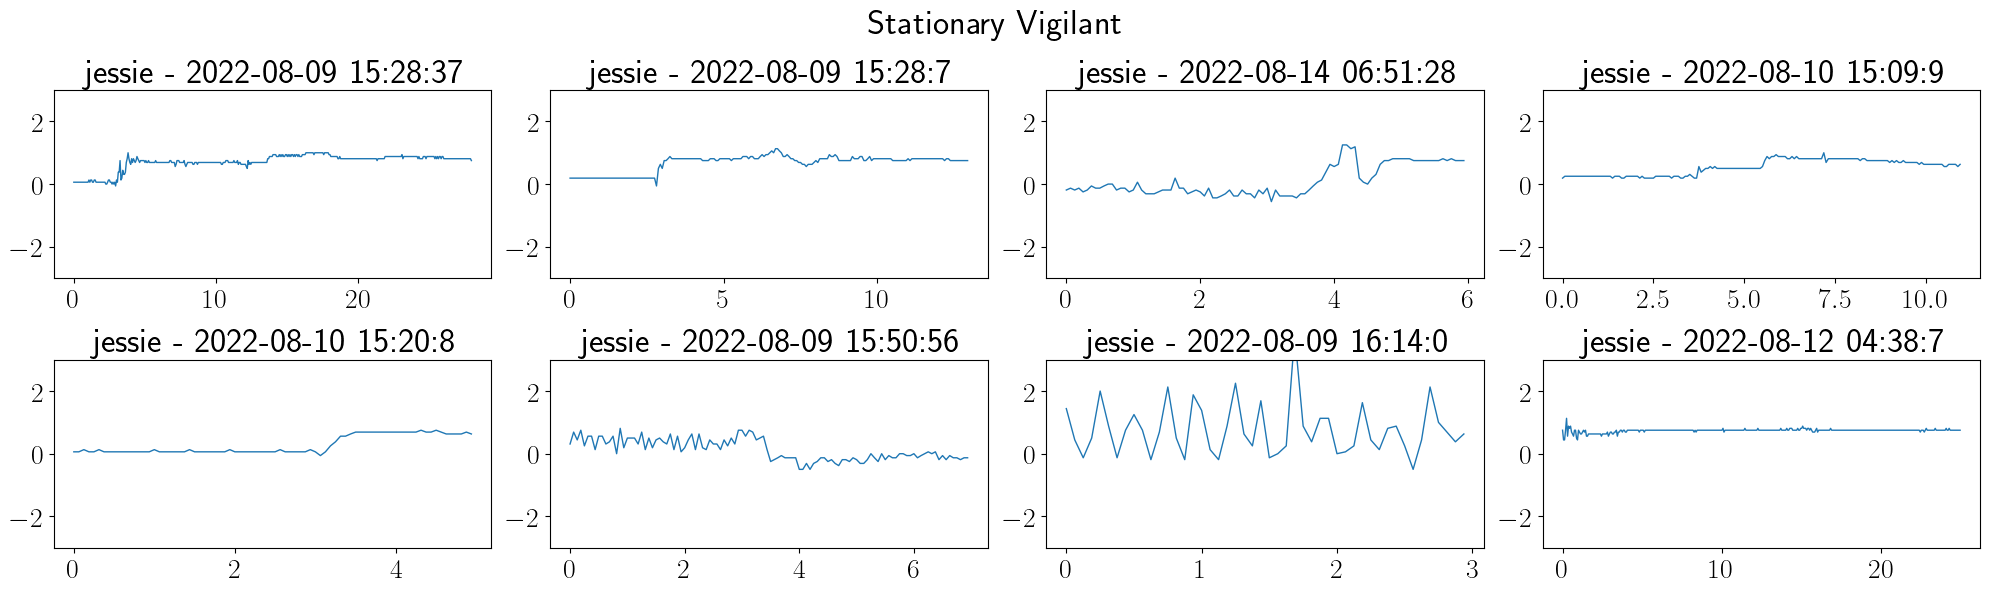

In [86]:
stationary_data = acc_data[acc_data['behavior'] == 'Stationary vigilant'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(stationary_data.iloc[idx[i]]['acc_x']))/16, stationary_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = stationary_data.iloc[idx[i]]['dog ID'], pd.to_datetime(stationary_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Stationary Vigilant', fontsize=25)
plt.tight_layout()
plt.show()


#### Resting

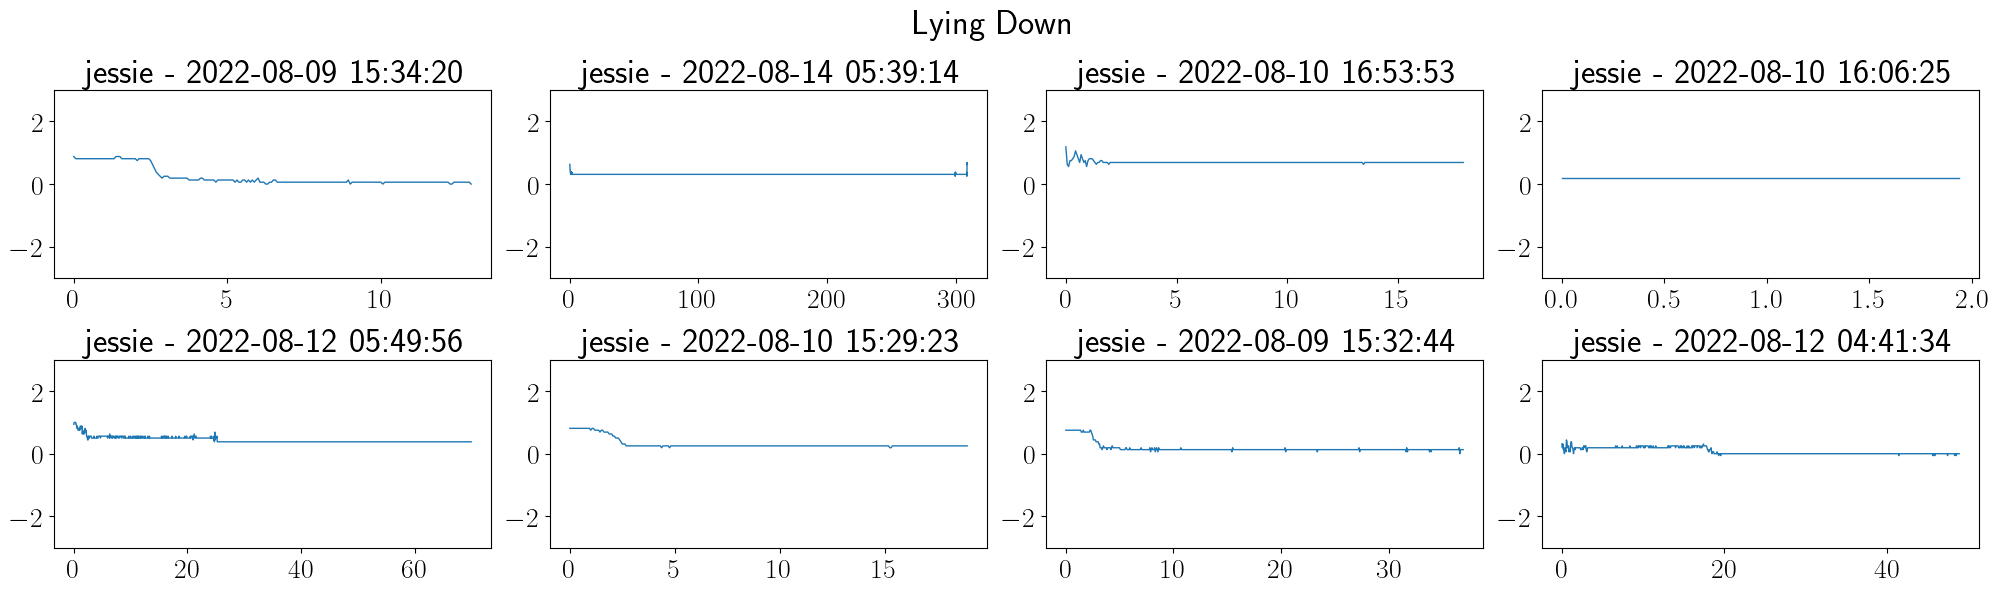

In [87]:
lying_data = acc_data[acc_data['behavior'] == 'Lying down'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(lying_data.iloc[idx[i]]['acc_x']))/16, lying_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = lying_data.iloc[idx[i]]['dog ID'], pd.to_datetime(lying_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Lying Down', fontsize=25)
plt.tight_layout()
plt.show()
